### PyKGML: Quick Start Example
This notebook demonstrates the use of [**PyKGML**](https://github.com/AI4Agriculture/PyKGML_development), a Python libaray for efficient KGML development. 

In this example, we will learn how to predict GHG (CO<sub>2</sub>/N<sub>2</sub>O) fluxes using the provided dataset.


In [2]:
# import necessary python library
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

### Import classes from PyKGML library
1. **dataset** The example dataset contains four components:  
    - co2_pretrain_data (Synthetic data of CO2 fluxes generated by ecosys)  
    - co2_finetune_data (Field observations of CO2 fluxes from flux towers)
    - n2o_pretrain_data (Synthetic data of N2O fluxes generated by ecosys)  
    - n2o_finetune_augment_data (Augmented chamber observations of N2O fluxes in a mesocosm environment)  

    The CO2 datasets are from Liu et al., 2024: https://www.nature.com/articles/s41467-023-43860-5  
    The N2O datasets are from Liu et al., 2022: https://doi.org/10.5194/gmd-15-2839-2022

2. From **time_series_models**, users can select one model among:  
    - Attention
    - GRUSeq2Seq
    - LSTMSeq2Seq
    - GRUSeq2SeqWithAttention
    - 1dCNN
    - TimeSeriesTransformer
    - N2OGRU_KGML (This is the KGMLag-N2O model (structure only) from Liu et al., 2022)
    - RecoGRU_KGML (This is the KGMLag-CO2 model (structure only) from Liu et al., 2024)  

    **SequenceDataset** is a class that prepares the dataset as samples with a specified sequence length and stores them along with the corresponding labels.  
    It works with PyTorch’s **DataLoader** to create an iterable to enable easy access to the samples.


3. **kgml_lib** stores defined utility functions:
    - normalization (Z_norm, Z_norm_with_scaler, Z_norm_reverse), 
    - Loss function design (LossCompiler), 
    - Model structure design (ModelCompiler)



In [4]:
from time_series_models import GRUSeq2SeqWithAttention, SequenceDataset
from dataset import N2O_synthetic_dataset, plot_features
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE" # ignore duplicate library loading errors.

### Dataset information
1. Loading method  
The example dataset was standardized by Z-normalization and saved as a serialized disctionary object using torch.save().  
Torch.load() can be used to load the files: 'co2_pretrain_data.sav', 'co2_finetune_data.sav', 'n2o_pretrain_data.sav', 'n2o_finetune_augment_data.sav'.  
The keys in the loaded dataset will look like this:  
<pre>   
    ```python 
    co2_pretrain_data = {'X_train': X_train,  
                         'X_test': X_test,  
                         'Y_train': Y_train,  
                         'Y_test': Y_test,  
                         'y_scaler': y_scaler,  
                         'input_features':input_features,  
                         'output_features': output_features}   
    ``` </pre>
            
2. Dataset size and dimensions  
  - Input X shape: [sample, sequence_length, input_features]
  - Output Y shape: [sample, sequence_length, output_features]  
      
    1. co2_pretrain_data:  
        - 100 samples (one per site)
        - Each sample is a daily sequence over 18 years (6570) 
        - 19 input_features and 2 output_features  
          
    2. co2_finetune_data:  
        - One sample (11 sites were concatnated into one sequence due to varied sequence lengths)
        - A Daily sequence of total 124 site-years (45260 in length)
        - 19 input_features and 2 output_features  
             
    3. n2o_pretrain_data:  
        - 1980 samples (99 sites and 20 fertilizer rates at each site)
        - Each sample is a daily sequence over 18 years (6570 in length)
        - 16 input_features and 5 output_features  
          
    4. n2o_finetune_augment_data:  
        - 600 samples (6 sites and each has 1000 augmentation), 
        - Each sample is a daily sequence of 122 days over 3 years (366 in length)
        - 16 input_features and 5 output_features  

In [21]:
# Load dataset
data_path = '/Users/yufengyang/Documents/GitHub/data/PyKGML/'
output_path = data_path + 'test_results/CO2/'
if not os.path.exists(output_path):
    os.makedirs(output_path)

co2_pretrain_file = data_path + 'co2_pretrain_data.sav'
data = torch.load(co2_pretrain_file, weights_only=False)
print(data.keys())

dict_keys(['X_train', 'X_test', 'Y_train', 'Y_test', 'x_scaler', 'y_scaler', 'input_features', 'output_features'])


In [22]:
# Assign training and testing data. 
X_train, X_test, Y_train, Y_test = data['X_train'], data['X_test'], data['Y_train'], data['Y_test']
# y_scaler contains the means and stds. To reverse Y data to the original, use kgml.lib.Z_norm_reverse
x_scaler = data['x_scaler']
y_scaler = data['y_scaler']
input_features = data['input_features']
output_features = data['output_features']

print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape, x_scaler.shape, y_scaler.shape)
print(data['output_features'])


torch.Size([20, 6570, 19]) torch.Size([20, 6570, 3]) torch.Size([80, 6570, 19]) torch.Size([80, 6570, 3]) (21, 2) (3, 2)
['Ra', 'Rh', 'NEE']


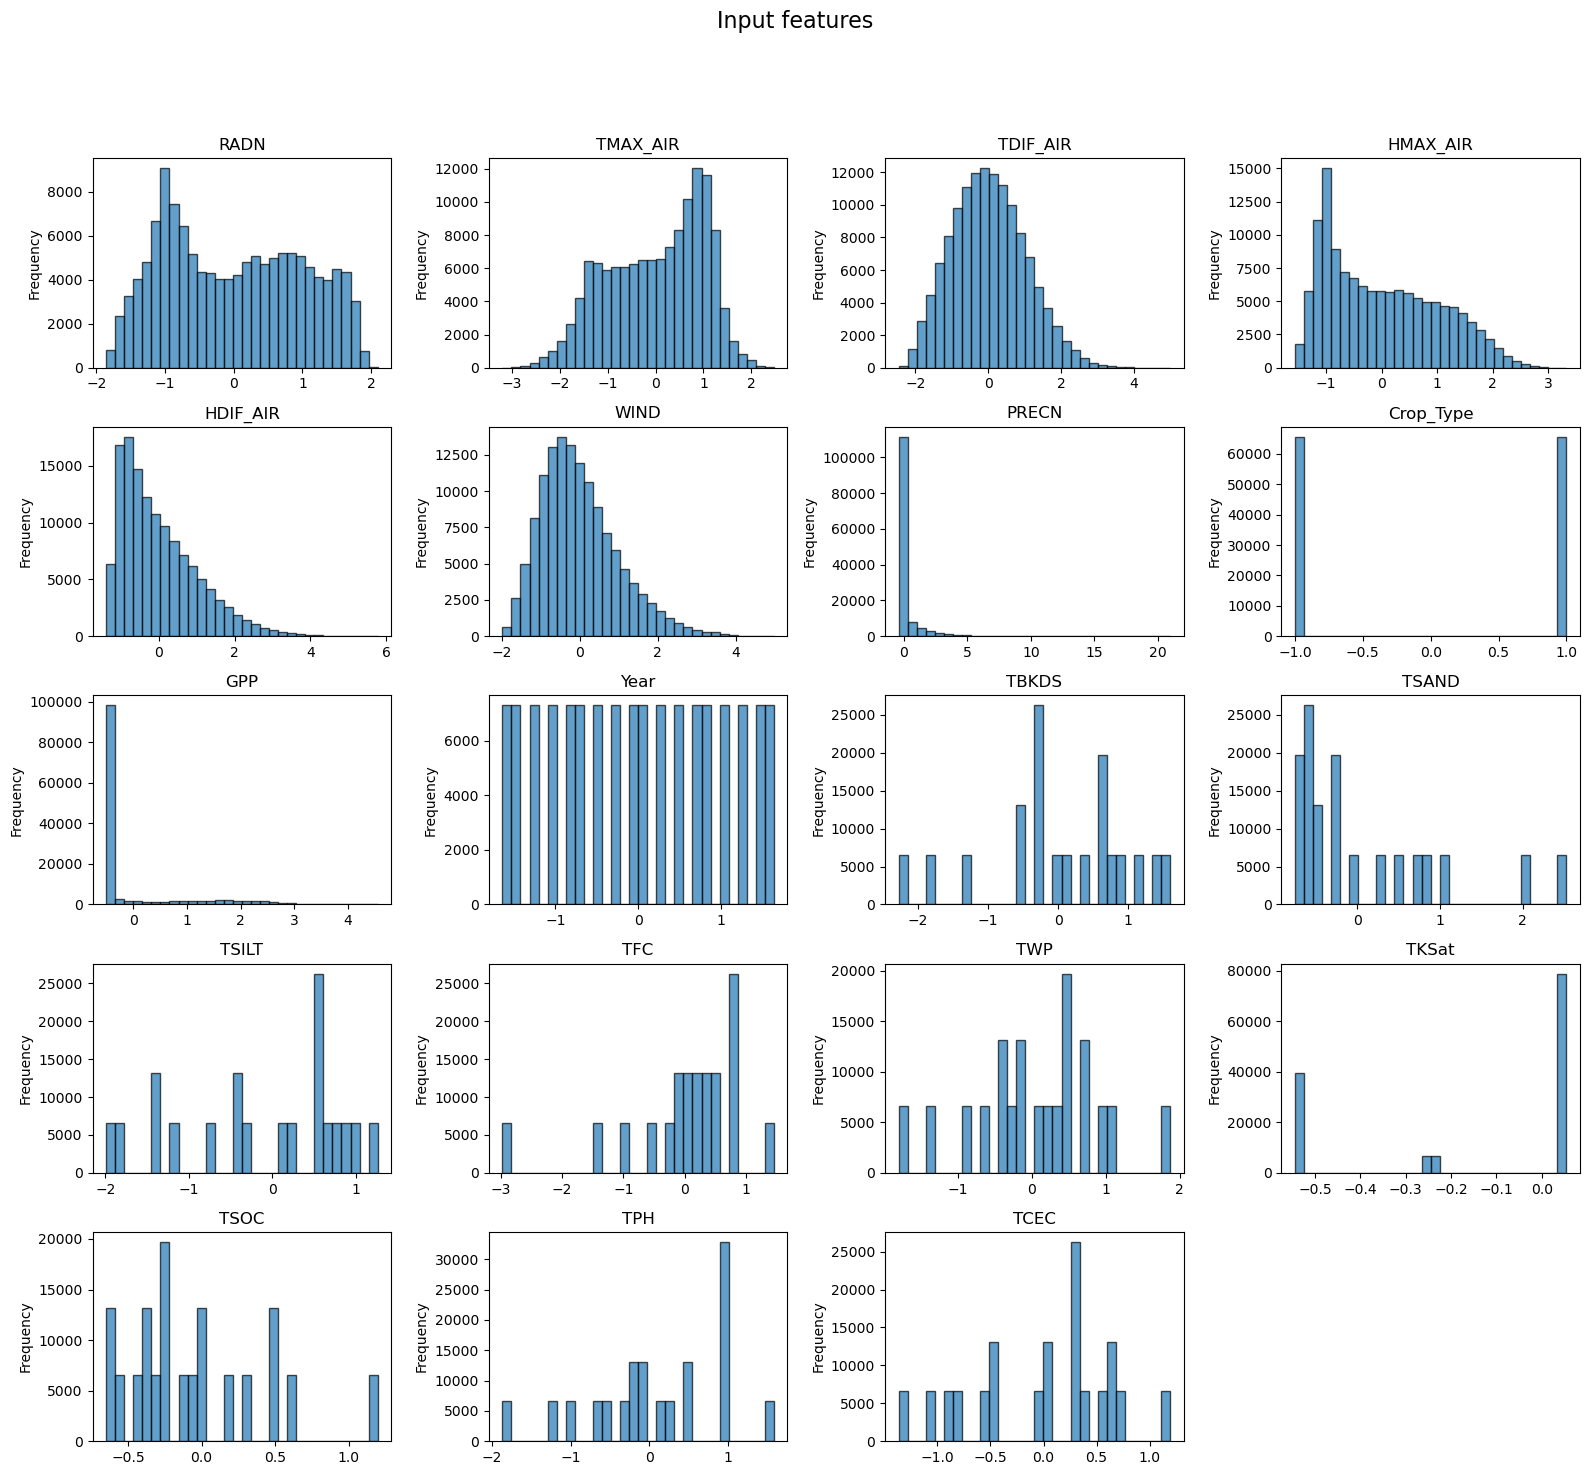

In [ ]:
# View histogram of input features
feature_len = len(input_features)
features = input_features
values = X_train.reshape(-1, feature_len)
sub_title = "Input features"
plot_features(values, feature_len, features, sub_title)

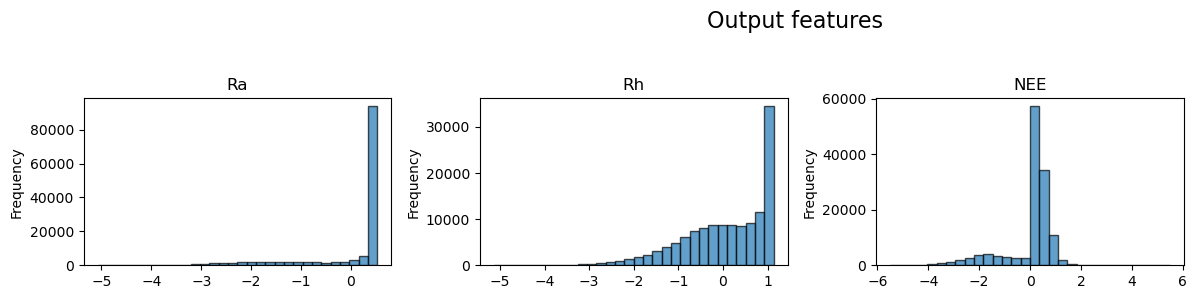

In [5]:
# View histogram of output features
feature_len = len(output_features)
features = output_features
values = Y_train.reshape(-1, feature_len)
sub_title = "Output features"
plot_features(values, feature_len, features, sub_title)

### Model selections and their parameters:  

- LSTMSeq2Seq(input_dim, hidden_dim, num_layers, output_dim)   

- GRUSeq2Seq(input_dim, hidden_dim, num_layers, output_dim) 

- Attention(input_dim, hidden_dim, num_layers, output_dim) 

- GRUSeq2SeqWithAttention(input_dim, hidden_dim, num_layers, output_dim, dropout)   

- 1dCNN(input_dim, hidden_dim, num_layers, output_dim, dropout) 

- CNNLSTM(input_dim, hidden_dim, num_layers, output_dim, dropout) 

- CNN_LSTM_Attension(input_dim, hidden_dim, num_layers, output_dim, dropout) 

- N2OGRU_KGML(input_dim, hidden_dim, num_layers, output_dim1, output_dim2, dropout) 

- RecoGRU_KGML(input_dim, hidden_dim, num_layers, output_dim, dropout) 

- TimeSeriesTransformer(input_dim, hidden_dim, num_layers, output_dim, d_model,  nhead, dropout) 

In [5]:
# Set parameters for creating a Model
input_dim = len(input_features)
hidden_dim = 128
num_layers = 3
output_dim = len(output_features)
dropout=0.2

model = GRUSeq2SeqWithAttention(input_dim, hidden_dim, num_layers, output_dim, dropout)

In [11]:
# Create Pytorch dataloader
sequence_length = 365  # Use 365 consecutive days as a sample

# Create Dataset objects for training and testing.
train_dataset = SequenceDataset(X_train, Y_train, sequence_length)
test_dataset = SequenceDataset(X_test, Y_test, sequence_length)

# Create DataLoaders.
batch_size = 64
model.train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
model.test_loader  = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [ ]:
# set hyperparameters for model training
learning_rate = 0.001
step_size = 20
max_epoch = 60
gamma = 0.8
loss_function = nn.L1Loss()

model.train_model(loss_func=loss_function, LR=learning_rate, step_size=step_size, gamma=0.8, maxepoch=max_epoch)

Epoch 1/60 | LR: 0.001000, Train Loss: 0.6014, Test Loss: 0.5104
Epoch 2/60 | LR: 0.001000, Train Loss: 0.4470, Test Loss: 0.4467
Epoch 3/60 | LR: 0.001000, Train Loss: 0.3795, Test Loss: 0.3508
Epoch 4/60 | LR: 0.001000, Train Loss: 0.3029, Test Loss: 0.2908
Epoch 5/60 | LR: 0.001000, Train Loss: 0.2516, Test Loss: 0.2582
Epoch 6/60 | LR: 0.001000, Train Loss: 0.2301, Test Loss: 0.2350
Epoch 7/60 | LR: 0.001000, Train Loss: 0.2115, Test Loss: 0.2216
Epoch 8/60 | LR: 0.001000, Train Loss: 0.1988, Test Loss: 0.2140
Epoch 9/60 | LR: 0.001000, Train Loss: 0.1882, Test Loss: 0.2045
Epoch 10/60 | LR: 0.001000, Train Loss: 0.1803, Test Loss: 0.1952
Epoch 11/60 | LR: 0.001000, Train Loss: 0.1717, Test Loss: 0.1918
Epoch 12/60 | LR: 0.001000, Train Loss: 0.1693, Test Loss: 0.1865
Epoch 13/60 | LR: 0.001000, Train Loss: 0.1635, Test Loss: 0.1819
Epoch 14/60 | LR: 0.001000, Train Loss: 0.1576, Test Loss: 0.1839
Epoch 15/60 | LR: 0.001000, Train Loss: 0.1541, Test Loss: 0.1811
Epoch 16/60 | LR: 0

In [ ]:
# model testing using test_dataset
model.test()

Test Loss: 0.1750


### Visualization
Basic functions for visualizing the model prediction incude:  
- plot_training_curves(): # plot the loss curves of training and testing  
- Vis_plot_prediction_result_time_series(y_scaler, output_feature_name): visualize the predicted sequence vs. the true values at a specific site and year
- Vis_scatter_prediction_result(y_scaler, output_feature_name): visualize the predicted values vs. true values in scatters


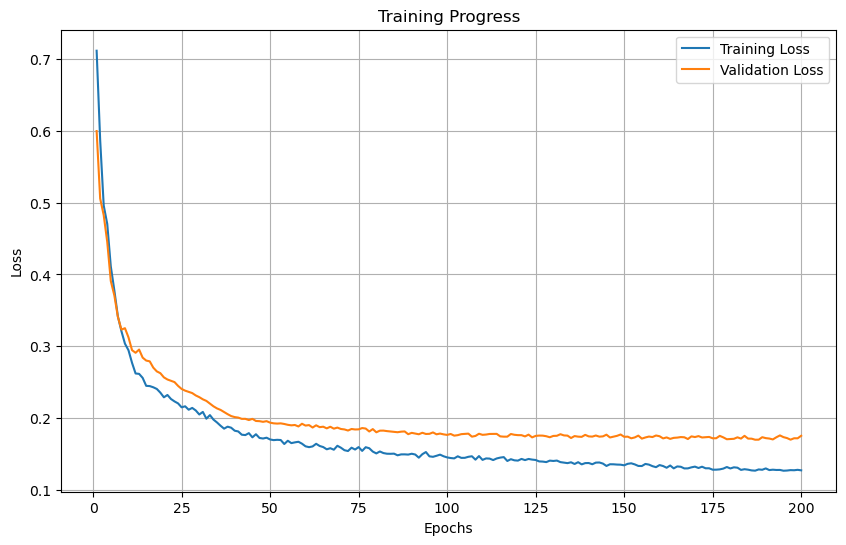

In [ ]:
model.plot_training_curves()

In [17]:
output_feature_name = ['NEE','RECO']
model.get_R2_score(y_scaler, output_feature_name)

Feature NEE R2 Score is: 0.936375464726363
Feature RECO R2 Score is: 0.8914221182159583


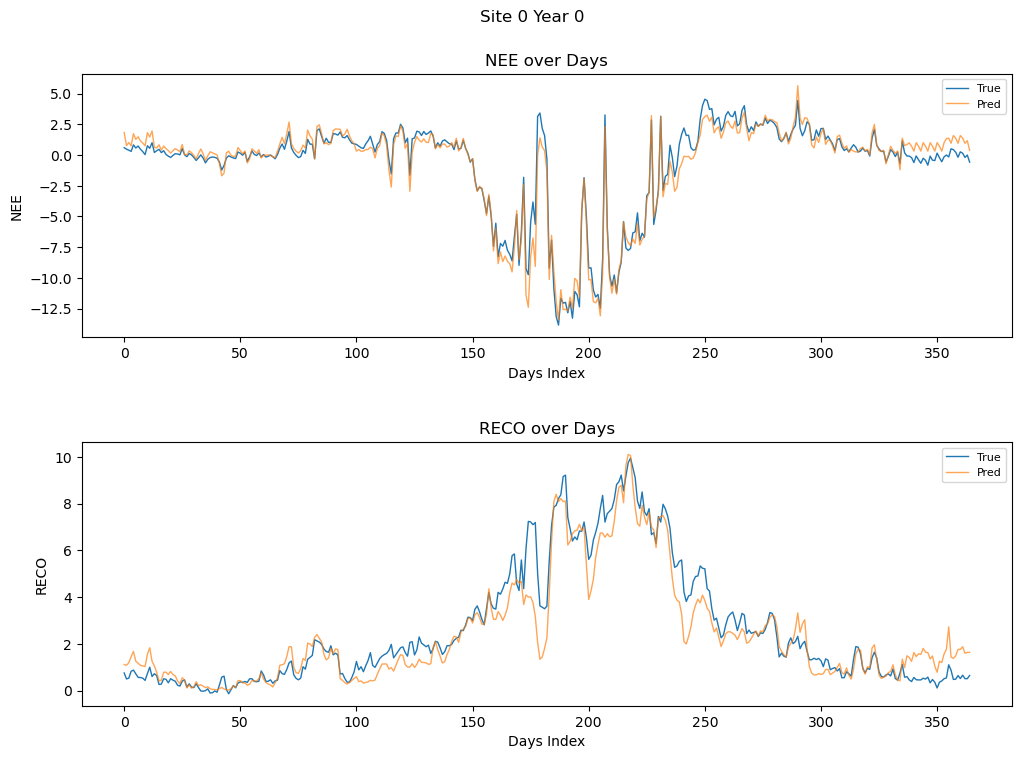

In [ ]:
model.Vis_plot_prediction_result_time_series(y_scaler, output_feature_name, site=0, year=0)

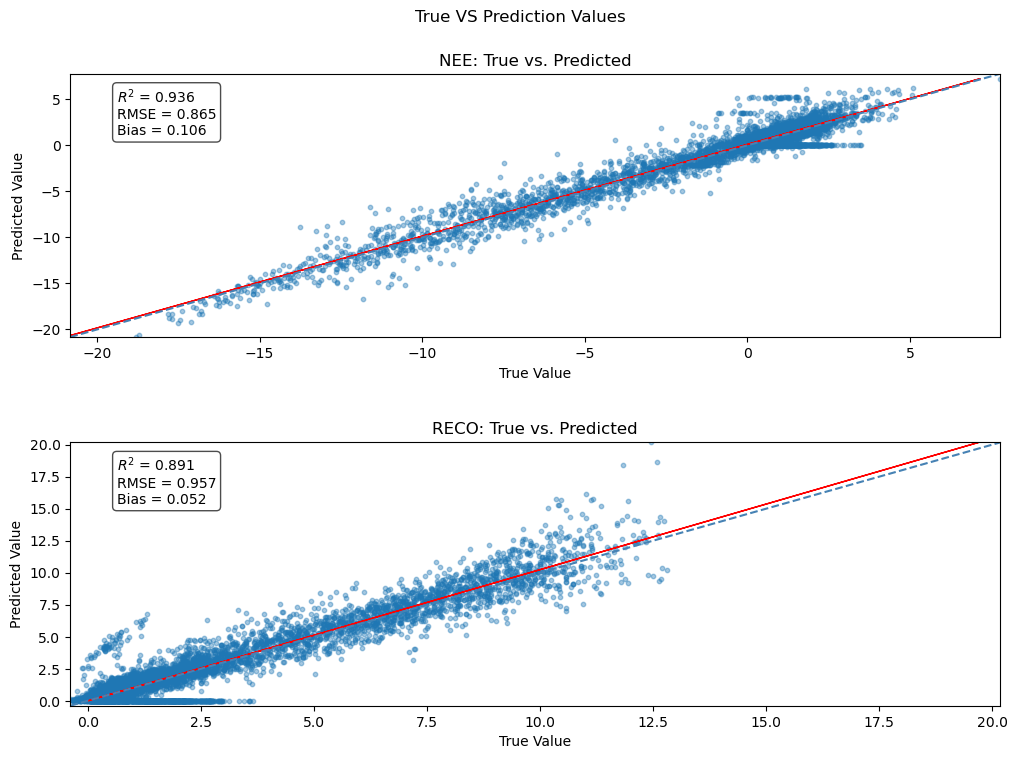

In [ ]:
model.Vis_scatter_prediction_result(y_scaler, output_feature_name)

In [13]:
# Load fine-tune dataset
data_path = '/Users/yufengyang/Documents/GitHub/data/PyKGML/'
co2_finetune_file = data_path + 'co2_finetune_data.sav'
finetune_data = torch.load(co2_finetune_file, weights_only=False)
print(finetune_data.keys())

# Assign training and testing data. 
X_train_ft, X_test_ft, Y_train_ft, Y_test_ft = finetune_data['X_train'], finetune_data['X_test'], finetune_data['Y_train'], finetune_data['Y_test']
# y_scaler contains the means and stds. To reverse Y data to the original, use kgml.lib.Z_norm_reverse
x_scaler_ft = finetune_data['x_scaler']
y_scaler_ft = finetune_data['y_scaler']
input_features_ft = finetune_data['input_features']
output_features_ft = finetune_data['output_features']


print(X_train_ft.shape, Y_train_ft.shape, X_test_ft.shape, Y_test_ft.shape)
print(input_features_ft,output_features_ft, y_scaler_ft)

dict_keys(['X_train', 'X_test', 'Y_train', 'Y_test', 'x_scaler', 'y_scaler', 'input_features', 'output_features'])
torch.Size([1, 37230, 19]) torch.Size([1, 37230, 2]) torch.Size([1, 8030, 19]) torch.Size([1, 8030, 2])
['RADN', 'TMAX_AIR', 'TDIF_AIR', 'HMAX_AIR', 'HDIF_AIR', 'WIND', 'PRECN', 'Crop_Type', 'GPP', 'Year', 'TBKDS', 'TSAND', 'TSILT', 'TFC', 'TWP', 'TKSat', 'TSOC', 'TPH', 'TCEC'] ['NEE', 'RECO'] tensor([[-0.5235,  2.9943],
        [-1.1666,  2.7217]], dtype=torch.float64)


In [28]:
# Customize a loss function using the help compiler from customize_loss.py
from customize_loss import CarbonFluxLossCompiler

# Scientific background
# -----------------------------------------------------------------------------------------------------------------------
# We want to predict daily autotrophic respiration (Ra), heterotrophic respiration (Rh), and net ecosystem exchange (NEE).
# These relations exist:
# Ecosystem respiration: Reco = Ra + Rh
# Mass balance: NEE = Reco - GPP
# Thus, except predicting Ra, Rh, and NEE, we want them to maintain the mass balance. GPP is a known input variable.
# -----------------------------------------------------------------------------------------------------------------------
# Loss function design
# loss1 = mean[MSE(Ra) + MSE(Rh) + MSE(NEE)]
# loss2 = abs(GPP - Reco + NEE_pred)
# loss = loss1 + loss2
# -----------------------------------------------------------------------------------------------------------------------

GPP_scaler = x_scaler_ft[8]
# configure a script for building a loss function
model_ft_config = {
    'parameters': {
        'GPP_idx': 8,
        'Ra_idx': 0,
        'Rh_idx': 1,
        'NEE_idx': 0,
        'RECO_idx': 1,
        'tol_MB': 0.01,
        'lamda': [0.1, 0.09],
        'aaa_scaler': x_scaler_ft,
        'bbb_scaler': y_scaler,
        'ccc_scaler':y_scaler_ft},
    # revise this part to remove scaler and z_norm_reverse. 1. scaling methods (pre-define) 2. scaler
    'variables': {
        'GPP': 'Z_norm_reverse(batch_x[:, :, GPP_idx], aaa_scaler[GPP_idx])',
        'Ra_pred': 'Z_norm_reverse(y_pred[:, :, Ra_idx], bbb_scaler[Ra_idx])',
        'Rh_pred': 'Z_norm_reverse(y_pred[:, :, Rh_idx], bbb_scaler[Rh_idx])',
        'NEE_pred': 'Z_norm_reverse(y_pred[:, :, NEE_idx], ccc_scaler[NEE_idx])',
        'NEE_true': 'Z_norm_reverse(y_true[:, :, NEE_idx], ccc_scaler[NEE_idx])',
        'RECO_true': 'Z_norm_reverse(y_true[:, :, RECO_idx], ccc_scaler[RECO_idx])',
        },
    
    'loss_fomula': {
        'Reco': 'Ra_pred + Rh_pred',
        'loss1': 'mean((NEE_pred - NEE_true)**2 + (Reco - RECO_true)**2)',
        'loss2': 'abs(GPP - Reco + NEE_pred) - tol_MB * abs(Reco)',
        'loss': 'mean(lamda[0]*loss1 + lamda[1]*loss2)',}
    }

# Create the compiler
compiler_ft = CarbonFluxLossCompiler(model_ft_config)

# Print the created loss class code
print("Generated CarbonFluxLoss:")
print(compiler_ft.class_code)

# Create loss class
CarbonFluxLoss = compiler_ft.generate_class()
loss_fn_ft = CarbonFluxLoss()

Generated CarbonFluxLoss:
import torch
import torch.nn as nn

class CarbonFluxLoss(nn.Module):
    def __init__(self, GPP_idx=8, Ra_idx=0, Rh_idx=1, NEE_idx=0, RECO_idx=1, tol_MB=0.01, lamda=[0.1, 0.09], aaa_scaler=[[0.0307764932513237, 0.8278915286064148], [15.056167602539062, 7.328380584716797], [17.22715187072754, 12.243897438049316], [10.011832237243652, 3.9239165782928467], [1.4299079179763794, 0.8656227588653564], [0.4202100932598114, 0.2988949716091156], [377.0799255371094, 144.39683532714844], [2.7723302841186523, 7.165937900543213], [0.002739726100116968, 0.052270278334617615], [0.6111111044883728, 0.48750051856040955], [1.4411814212799072, 0.06339188665151596], [214.7544403076172, 134.0675048828125], [535.9190063476562, 111.13461303710938], [6.51896333694458, 0.42865416407585144], [19.679845809936523, 3.732316732406616], [19.628433227539062, 5.622049808502197], [-0.00048473241622559726, 0.0019419103628024459], [-1.7216215133666992, 1.5835059881210327], [0.30386826395988464, 0

In [24]:
# model_ft = model.load_state_dict(checkpoint)
input_dim = len(input_features_ft)
hidden_dim = 128
num_layers = 3
output_dim = len(output_features)
dropout=0.2

# reload model weights
checkpoint_path = './Best_model.pth'
checkpoint = torch.load(checkpoint_path, weights_only=True)
model_ft = GRUSeq2SeqWithAttention(input_dim, hidden_dim, num_layers, output_dim, dropout)
model_ft.load_pretrained(pretrained_model_path=checkpoint_path)

GRUSeq2SeqWithAttention(
  (gru): GRU(19, 128, num_layers=3, batch_first=True)
  (attention): Attention(
    (query): Linear(in_features=128, out_features=128, bias=True)
    (key): Linear(in_features=128, out_features=128, bias=True)
    (value): Linear(in_features=128, out_features=128, bias=True)
  )
  (fc): Linear(in_features=256, out_features=3, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)
Model's state_dict:
gru.weight_ih_l0 	 torch.Size([384, 19])
gru.weight_hh_l0 	 torch.Size([384, 128])
gru.bias_ih_l0 	 torch.Size([384])
gru.bias_hh_l0 	 torch.Size([384])
gru.weight_ih_l1 	 torch.Size([384, 128])
gru.weight_hh_l1 	 torch.Size([384, 128])
gru.bias_ih_l1 	 torch.Size([384])
gru.bias_hh_l1 	 torch.Size([384])
gru.weight_ih_l2 	 torch.Size([384, 128])
gru.weight_hh_l2 	 torch.Size([384, 128])
gru.bias_ih_l2 	 torch.Size([384])
gru.bias_hh_l2 	 torch.Size([384])
attention.query.weight 	 torch.Size([128, 128])
attention.query.bias 	 torch.Size([128])
attention.key.weight 

In [26]:
# Create Pytorch dataloader
sequence_length = 365  # Use 365 consecutive days as a sample

# Create Dataset objects for training and testing.
train_dataset_ft = SequenceDataset(X_train_ft, Y_train_ft, sequence_length)
test_dataset_ft = SequenceDataset(X_test_ft, Y_test_ft, sequence_length)

# Create DataLoaders.
batch_size = 64
model_ft.train_loader = DataLoader(train_dataset_ft, batch_size=batch_size, shuffle=True)
model_ft.test_loader  = DataLoader(test_dataset_ft, batch_size=1, shuffle=False)

In [30]:
# set hyperparameters for model training
learning_rate = 0.001
step_size = 40
max_epoch = 200
gamma = 0.8
loss_function = nn.L1Loss()
# loss funtion 
model_ft.train_model(loss_func=loss_fn_ft, LR=learning_rate, step_size=step_size, gamma=0.8, maxepoch=max_epoch)

Epoch 1/200 | LR: 0.001000, Train Loss: 1.6011, Test Loss: 1.3872
Epoch 2/200 | LR: 0.001000, Train Loss: 1.3920, Test Loss: 1.1359
Epoch 3/200 | LR: 0.001000, Train Loss: 1.1558, Test Loss: 0.8855
Epoch 4/200 | LR: 0.001000, Train Loss: 0.8915, Test Loss: 0.8138
Epoch 5/200 | LR: 0.001000, Train Loss: 0.8650, Test Loss: 0.8275
Epoch 6/200 | LR: 0.001000, Train Loss: 0.8589, Test Loss: 0.7566
Epoch 7/200 | LR: 0.001000, Train Loss: 0.7356, Test Loss: 0.7084
Epoch 8/200 | LR: 0.001000, Train Loss: 0.6535, Test Loss: 0.6864
Epoch 9/200 | LR: 0.001000, Train Loss: 0.6290, Test Loss: 0.6508
Epoch 10/200 | LR: 0.001000, Train Loss: 0.6075, Test Loss: 0.6011
Epoch 11/200 | LR: 0.001000, Train Loss: 0.5618, Test Loss: 0.5685
Epoch 12/200 | LR: 0.001000, Train Loss: 0.5621, Test Loss: 0.5538
Epoch 13/200 | LR: 0.001000, Train Loss: 0.5400, Test Loss: 0.5357
Epoch 14/200 | LR: 0.001000, Train Loss: 0.5296, Test Loss: 0.5328
Epoch 15/200 | LR: 0.001000, Train Loss: 0.5261, Test Loss: 0.5360
Epoc

/Users/yufengyang/Documents/GitHub/PyKGML_development/time_series_models.py:439: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(checkpoint_pat

In [ ]:
# Load the CO2_pretrain dataset
root_dir = '/Users/yufengyang/Library/CloudStorage/GoogleDrive-yang6956@umn.edu/My Drive/KGML/PyKGML/datasets/'
data_path = root_dir +  'processed_data/CO2/' # for the N2O dataset: data_path = root_dir +  'N2O/'  
output_path = root_dir + 'test_results/CO2/'
if not os.path.exists(output_path):
    os.makedirs(output_path)

co2_pretrain_file = data_path + 'co2_pretrain_data.sav'
data = torch.load(co2_pretrain_file, weights_only=False)
# Assign training and testing data. 
X_train, X_test, Y_train, Y_test = data['X_train'], data['X_test'], data['Y_train'], data['Y_test']
# y_scaler contains the means and stds. To reverse Y data to the original, use kgml.lib.Z_norm_reverse
x_scaler = data['x_scaler']
y_scaler = data['y_scaler']

# Create Pytorch dataloader
sequence_length = 365  # Use 365 consecutive days as a sample

# Create Dataset objects for training and testing.
train_dataset = SequenceDataset(X_train, Y_train, sequence_length)
test_dataset = SequenceDataset(X_test, Y_test, sequence_length)

In [ ]:
# Customize a loss function using the help compiler from customize_loss.py
from customize_loss import CarbonFluxLossCompiler

# Scientific background
# -----------------------------------------------------------------------------------------------------------------------
# We want to predict daily autotrophic respiration (Ra), heterotrophic respiration (Rh), and net ecosystem exchange (NEE).
# These relations exist:
# Ecosystem respiration: Reco = Ra + Rh
# Mass balance: NEE = Reco - GPP
# Thus, except predicting Ra, Rh, and NEE, we want them to maintain the mass balance. GPP is a known input variable.
# -----------------------------------------------------------------------------------------------------------------------
# Loss function design
# loss1 = mean[MSE(Ra) + MSE(Rh) + MSE(NEE)]
# loss2 = abs(GPP - Reco + NEE_pred)
# loss = loss1 + loss2
# -----------------------------------------------------------------------------------------------------------------------

GPP_scaler = x_scaler[8]
# configure a script for building a loss function
script_config = {
    'parameters': {
        'GPP_idx': 8,
        'Ra_idx': 0,
        'Rh_idx': 1,
        'NEE_idx': 2,
        'tol_MB': 0.01,
        'lamda': [0.1, 0.09],
        'aaa_scaler': GPP_scaler,
        'ccc_scaler':y_scaler},
    # revise this part to remove scaler and z_norm_reverse. 1. scaling methods (pre-define) 2. scaler
    'variables': {
        'GPP': 'Z_norm_reverse(batch_x[:, :, GPP_idx], aaa_scaler)',
        'Ra_pred': 'Z_norm_reverse(y_pred[:, :, Ra_idx], ccc_scaler[Ra_idx])',
        'Rh_pred': 'Z_norm_reverse(y_pred[:, :, Rh_idx], ccc_scaler[Rh_idx])',
        'NEE_pred': 'Z_norm_reverse(y_pred[:, :, NEE_idx], ccc_scaler[NEE_idx])',
        'Ra_true': 'Z_norm_reverse(y_true[:, :, Ra_idx], ccc_scaler[Ra_idx])',
        'Rh_true': 'Z_norm_reverse(y_true[:, :, Rh_idx], ccc_scaler[Rh_idx])',
        'NEE_true': 'Z_norm_reverse(y_true[:, :, NEE_idx], ccc_scaler[NEE_idx])',
        },
    
    'loss_fomula': {
        'Reco': 'Ra_pred + Rh_pred',
        'loss1': 'mean((Ra_pred - Ra_true)**2 + (Rh_pred - Rh_true)**2 + (NEE_pred - NEE_true)**2)',
        'loss2': 'abs(GPP - Reco + NEE_pred) - tol_MB * abs(Reco)',
        'loss': 'mean(lamda[0]*loss1 + lamda[1]*loss2)',}
    }

In [ ]:
# Create the compiler
compiler = CarbonFluxLossCompiler(script_config)

# Print the created loss class code
print("Generated CarbonFluxLoss:")
print(compiler.class_code)

# Create loss class
CarbonFluxLoss = compiler.generate_class()
loss_fn = CarbonFluxLoss()

Generated CarbonFluxLoss:
import torch
import torch.nn as nn

class CarbonFluxLoss(nn.Module):
    def __init__(self, GPP_idx=8, Ra_idx=0, Rh_idx=1, NEE_idx=2, tol_MB=0.01, lamda=[0.1, 0.09], aaa_scaler=[2.8892129010294383, 5.757924175519595], ccc_scaler=[[-1.3584023714065552, 2.5833351612091064], [-0.9747186899185181, 0.8566842675209045], [-0.5235359072685242, 2.9942545890808105]]):
        super().__init__()
        self.GPP_idx = GPP_idx
        self.Ra_idx = Ra_idx
        self.Rh_idx = Rh_idx
        self.NEE_idx = NEE_idx
        self.tol_MB = tol_MB
        self.lamda = lamda
        self.aaa_scaler = aaa_scaler
        self.ccc_scaler = ccc_scaler

    def forward(self, y_pred, y_true, batch_x):
        # Copy parameters to local variables
        GPP_idx = self.GPP_idx
        Ra_idx = self.Ra_idx
        Rh_idx = self.Rh_idx
        NEE_idx = self.NEE_idx
        tol_MB = self.tol_MB
        lamda = self.lamda
        aaa_scaler = self.aaa_scaler
        ccc_scaler = self.ccc

In [ ]:
num_input_features = X_train.shape[-1]
num_output_features = Y_train.shape[-1]

input_dim = num_input_features
hidden_dim = 128
num_layers = 2
output_dim = num_output_features

model = GRUSeq2SeqWithAttention(input_dim, hidden_dim, num_layers, output_dim)

# Create DataLoaders
batch_size = 64
model.train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
model.test_loader  = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [ ]:
learning_rate = 0.001
step_size = 20
max_epoch = 2

# model.train_model(train_loader, test_loader, LR= learning_rate, step_size=20, gamma=0.8, maxepoch=60)
model.train_model(loss_fun=loss_fn, LR= learning_rate, step_size= step_size, gamma=0.8, maxepoch=max_epoch)

Epoch 1/2 | LR: 0.001000, Train Loss: 1.5375, Test Loss: 1.3139
Epoch 2/2 | LR: 0.001000, Train Loss: 1.0209, Test Loss: 0.8585


In [ ]:
model.test()
model.plot_training_curves()

In [ ]:
output_feature_name = ['Ra','Rh','NEE']
model.get_R2_score(y_scaler, output_feature_name)

model.Vis_plot_prediction_result_time_series(y_scaler, output_feature_name, site=60, year=0)
model.Vis_scatter_prediction_result(y_scaler, output_feature_name)

In [5]:
# Customize a model structure using the help compiler from customize_module.py
from customize_module import FlexibleModelCompiler

# Plot a diagram of the model structure to help understand input/output dimensions and build the configure file.
# -----------------------------------------------------------------------------------------------------------------
# schematic model structure:
#                                                       inputs
#                                                         ⬇
#                                         cell1: gru_basic(inputs, output1) 
#                                                         ⬇
#               cell2: gru_ra(inputs + output1, output2)  ||  cell3: gru_rh(inputs + output1, output3))
#                                                         ⬇
#                                 cell4: gru_nee(inputs + output2 + output3, output4) 
#                                                         ⬇
#                       FClayer1(output2, Ra) || FClayer2(output3, Rh) || FClayer3(output4, NEE)
# -----------------------------------------------------------------------------------------------------------------
# input and output dimensions in each cell:
#                                                 inputs(inputs_dim)
#                                                         ⬇
#                                       cell1: gru_basic(inputs_dim, hidden_dim) 
#                                                         ⬇
#     cell2: gru_ra(inputs_dim + hidden_dim, hidden_dim)  ||  cell3: gru_rh(inputs_dim + hidden_dim, hidden_dim))
#                                                         ⬇
#                            cell4: gru_nee(inputs_dim + hidden_dim + hidden_dim, hidden_dim) 
#                                                         ⬇
#                       FClayer1(hidden_dim, 1) || FClayer2(hidden_dim, 1) || FClayer3(hidden_dim, 1)
# -----------------------------------------------------------------------------------------------------------------

config = {
    # define name and parameters
    'class_name': 'my_KGML',
    'base_class': 'TimeSeriesModel',
    'init_params': {
        'input_dim': 19,
        'hidden_dim': 128,
        'num_layers': 2,
        'output_dim': 3,
        'dropout': 0.2
    },
    # Define a dictionary of model components, where each key is a layer name and the value is a tuple specifying 
    # (layer type, input/output dimensions, and other parameters defined in torch.nn)
    'layers': {
            'gru_basic': ('gru', 'input_dim', 'hidden_dim', 'num_layers', 'dropout'),
            'gru_ra':    ('gru', 'input_dim + hidden_dim', 'hidden_dim', 'num_layers', 'dropout'),
            'gru_rh':    ('gru', 'input_dim + hidden_dim', 'hidden_dim', 'num_layers', 'dropout'),
            'gru_nee':   ('gru', 'input_dim+2', 'hidden_dim', 'num_layers', 'dropout'),
            'dropout':   ('dropout', 'dropout'),
            'fc':        ('linear', 'hidden_dim', '1'),
    },
    'forward': {
        'out_basic, hidden': 'gru_basic(x)',
        'dropped':   'dropout(out_basic)',
        'ra_in':     'x & dropped',
        'ra_out, hidden':    'gru_ra(ra_in)',
        'ra_pred':   'fc(dropout(ra_out))',
        'rh_in':     'x & dropped',
        'rh_out, hidden':    'gru_rh(rh_in)',
        'rh_pred':   'fc(dropout(rh_out))',
        'nee_in':    'x & ra_pred & rh_pred',
        'nee_out, hidden':   'gru_nee(nee_in)',
        'nee_pred':  'fc(dropout(nee_out))',
        'output':    'ra_pred & rh_pred & nee_pred'
    }
}


In [ ]:
# Feed the config to the pre-defined compiler. 
# Call generate_model() on the compiler to generate a model class. 
# Call class_code on the compiler to show the generated model structure.
Compiler = FlexibleModelCompiler(config)
myKGML = Compiler.generate_model()
print("\n Generated class code:")
print(Compiler.class_code)


 Generated class code:
class my_KGML(TimeSeriesModel):
    def __init__(self, input_dim=19, hidden_dim=128, num_layers=2, output_dim=3, dropout=0.2):
        super().__init__(input_dim, hidden_dim, num_layers, output_dim, dropout)
        self.gru_basic = nn.GRU(input_dim, hidden_dim, num_layers, bias=True, batch_first=True, dropout=dropout)
        self.gru_ra = nn.GRU(input_dim + hidden_dim, hidden_dim, num_layers, bias=True, batch_first=True, dropout=dropout)
        self.gru_rh = nn.GRU(input_dim + hidden_dim, hidden_dim, num_layers, bias=True, batch_first=True, dropout=dropout)
        self.gru_nee = nn.GRU(input_dim+2, hidden_dim, num_layers, bias=True, batch_first=True, dropout=dropout)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x: torch.Tensor):
        out_basic, hidden = self.gru_basic(x)
        dropped = self.dropout(out_basic)
        ra_in = torch.cat([x, dropped], dim=-1)
        ra_out, hidden = self.gru

In [ ]:
# define model parameters as the same in config
num_input_features = X_train.shape[-1]
num_output_features = Y_train.shape[-1]
input_dim = num_input_features
hidden_dim = 128
num_layers = 2
output_dim = num_output_features
dropout=0.2

model = myKGML(input_dim, hidden_dim, num_layers, output_dim, dropout)

# Create DataLoaders
batch_size = 64
model.train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
model.test_loader  = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [62]:
learning_rate = 0.001
step_size = 40
max_epoch = 2
gamma = 0.8
loss_function = nn.L1Loss() # nn.MSELoss()

# model.train_model(train_loader, test_loader, LR= learning_rate, step_size=20, gamma=0.8, maxepoch=60)
model.train_model(loss_fun=loss_function, LR= learning_rate, step_size= step_size, gamma=0.8, maxepoch=max_epoch)

Epoch 1/2 | LR: 0.001000, Train Loss: 0.3582, Test Loss: 0.3068
Epoch 2/2 | LR: 0.001000, Train Loss: 0.2604, Test Loss: 0.2590


In [ ]:
model.test()
model.plot_training_curves()

In [ ]:
output_feature_name = ['Ra','Rh','NEE']
model.get_R2_score(y_scaler, output_feature_name)

model.Vis_plot_prediction_result_time_series(y_scaler, output_feature_name, site=60, year=0)
model.Vis_scatter_prediction_result(y_scaler, output_feature_name)

In [19]:
# Attention head 
config_attn = {
        'class_name': 'my_attention',
        'base_class': 'nn.Module',
        'init_params': {
            'hidden_dim': 128,
        },
        'layers': {
            'fc1':        ('linear', 'hidden_dim', '64'),
            'relu': ('relu',),
            'fc2': ('linear', '64', '64'),
            'fc3': ('linear', '60', '32'),
            'fc4': ('linear', '32', '1'),
            'tanh': ('tanh',)
        },
        'forward': {
            'x1': 'fc1(x)',
            'x2':   'relu(x1)',
            'x3':    'fc2(x2)',
            'x4':     'relu(x3)',
            'x5':    'fc3(x4)',
            'x6':   'relu(x5)',
            'x7':    'fc4(x6)',
            'x8':   'tanh(x7)',
            'output':    'x8'
        }
    }

Compiler_kgml = FlexibleModelCompiler(config_attn)
Compiler_kgml.check_configuration()
myKGML = Compiler_kgml.generate_model()
print("\n Generated class code:")
print(Compiler_kgml.class_code)


 Generated class code:
class my_attention(nn.Module):
    def __init__(self, hidden_dim=128):
        super().__init__()

        self.hidden_dim = hidden_dim

        self.fc1 = nn.Linear(hidden_dim, 64)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(60, 32)
        self.fc4 = nn.Linear(32, 1)
        self.tanh = nn.Tanh()

    def forward(self, x: torch.Tensor):
        # Copy parameter to local
        hidden_dim = self.hidden_dim

        x1 = self.fc1(x)
        x2 = self.relu(x1)
        x3 = self.fc2(x2)
        x4 = self.relu(x3)
        x5 = self.fc3(x4)
        x6 = self.relu(x5)
        x7 = self.fc4(x6)
        x8 = self.tanh(x7)
        output = x8
        return output


In [ ]:
# Attention module
dual_attn = {
        'class_name': 'dual_attention',
        'base_class': 'nn.Module',
        'init_params': {
            'hidden_dim': 128,
        },
        'layers':{
            'fc':        ('linear', 'hidden_dim', 'hidden_dim'),

        },
        'forward': {
            'Q': 'fc(x)',
            'K': 'fc(x)',
            'V': 'fc(x)',
            '_scores': 'Q @ K.transpose(1, 2)',  # @ means matrix multiplication
            'scores': '_scores / (hidden_dim**0.5)', # scaling factor, torch.bmm(Q, K.transpose(1, 2)) / scaler
            'attention_weights': 'F.softmax(scores, dim=-1)',
            'context': 'attention_weights @ V', #torch.bmm(attention_weights, V)
            'output': 'x & context',
        }
    }
# add a list of forbidden signs in name: 
Compiler_kgml = FlexibleModelCompiler(dual_attn)
Compiler_kgml.check_configuration()
myKGML = Compiler_kgml.generate_model()
print("\n Generated class code:")
print(Compiler_kgml.class_code)


 Generated class code:
class dual_attention(nn.Module):
    def __init__(self, hidden_dim=128):
        super().__init__()

        self.hidden_dim = hidden_dim

        self.fc = nn.Linear(hidden_dim, hidden_dim)

    def forward(self, x: torch.Tensor):
        # Copy parameter to local
        hidden_dim = self.hidden_dim

        Q = self.fc(x)
        K = self.fc(x)
        V = self.fc(x)
        _scores = torch.bmm(Q, K.transpose(1, 2))
        scores = _scores / (hidden_dim**0.5)
        attention_weights = F.softmax(scores, dim=-1)
        context = torch.bmm(attention_weights, V)
        output = torch.cat([x, context], dim=-1)
        return output


In [15]:
# Multiple LSTM layers
config_kgml = {
        'class_name': 'my_KGML',
        'base_class': 'TimeSeriesModel',
        'init_params': {
            'input_dim': 19, # number of input features
            'hidden_dim': 128,
            'num_layers': 2,
            'output_dim': 3,
            'dropout': 0.2
        },
        'layers': {
            'lstm_basic': ('lstm', 'input_dim', 'hidden_dim', 'num_layers', 'dropout'), # basic by using LSTM
            'lstm_ra':    ('lstm', 'input_dim + 2*hidden_dim', 'hidden_dim', 'num_layers', 'dropout'), # Ra prediction
            'lstm_rh':    ('lstm', 'input_dim + 2*hidden_dim', 'hidden_dim', '1', '0'),
            'lstm_nee':   ('lstm', 'input_dim+2', 'hidden_dim', '1', '0'),
            'dropout':   ('dropout', 'dropout'),
            'fc':        ('linear', 'hidden_dim', '1'),
            'attn1':      ('Attention', 'hidden_dim', 'hidden_dim*2'), # Use predefined Attention class
        },
        'forward': {
            # gru layer return two parameters, ignore hidden
            'out_basic, hidden': 'lstm_basic(x)',
            'dropped':   'dropout(out_basic)',
            'attend':    'attn1(dropped)',
            'ra_in':     'attend & x',
            'ra_out, hidden':    'lstm_ra(ra_in)',  # Ignor hidden
            'ra_pred':   'fc(dropout(ra_out))',
            'rh_in':     'attend & x',
            'rh_out, hidden':    'lstm_rh(rh_in)',
            'rh_pred':   'fc(dropout(rh_out))',
            'nee_in':    'ra_pred & rh_pred & x',
            'nee_out, hidden':   'lstm_nee(nee_in)',
            'nee_pred':  'fc(dropout(nee_out))',
            'output':    'ra_pred & rh_pred & nee_pred'
        }
    }

Compiler_kgml = FlexibleModelCompiler(config_kgml)
Compiler_kgml.check_configuration()
myKGML = Compiler_kgml.generate_model()
print("\n Generated class code:")
print(Compiler_kgml.class_code)


 Generated class code:
class my_KGML(TimeSeriesModel):
    def __init__(self, input_dim=19, hidden_dim=128, num_layers=2, output_dim=3, dropout=0.2):
        super().__init__(input_dim, hidden_dim, num_layers, output_dim, dropout)

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.output_dim = output_dim
        self.dropout = dropout

        self.lstm_basic = nn.LSTM(input_dim, hidden_dim, num_layers, bias=True, batch_first=True, dropout=dropout)
        self.lstm_ra = nn.LSTM(input_dim + 2*hidden_dim, hidden_dim, num_layers, bias=True, batch_first=True, dropout=dropout)
        self.lstm_rh = nn.LSTM(input_dim + 2*hidden_dim, hidden_dim, 1, bias=True, batch_first=True, dropout=0)
        self.lstm_nee = nn.LSTM(input_dim+2, hidden_dim, 1, bias=True, batch_first=True, dropout=0)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim, 1)
        self.attn1 = Attention(hidden_dim)

    d